Training VGG18...
Epoch 1/20
157/157 [==============================] - 190s 1s/step - loss: 2.1998 - accuracy: 0.1518 - val_loss: 2.1446 - val_accuracy: 0.1896 - lr: 1.0000e-04
Epoch 2/20
157/157 [==============================] - 183s 1s/step - loss: 2.0031 - accuracy: 0.2252 - val_loss: 1.8589 - val_accuracy: 0.2755 - lr: 1.0000e-04
Epoch 3/20
157/157 [==============================] - 181s 1s/step - loss: 1.8907 - accuracy: 0.2802 - val_loss: 1.7940 - val_accuracy: 0.3221 - lr: 1.0000e-04
Epoch 4/20
157/157 [==============================] - 183s 1s/step - loss: 1.7946 - accuracy: 0.3166 - val_loss: 1.7371 - val_accuracy: 0.3418 - lr: 1.0000e-04
Epoch 5/20
157/157 [==============================] - 178s 1s/step - loss: 1.7170 - accuracy: 0.3472 - val_loss: 1.5938 - val_accuracy: 0.3987 - lr: 1.0000e-04
Epoch 6/20
157/157 [==============================] - 179s 1s/step - loss: 1.6479 - accuracy: 0.3848 - val_loss: 1.5597 - val_accuracy: 0.4221 - lr: 1.0000e-04
Epoch 7/20
157/157 [==

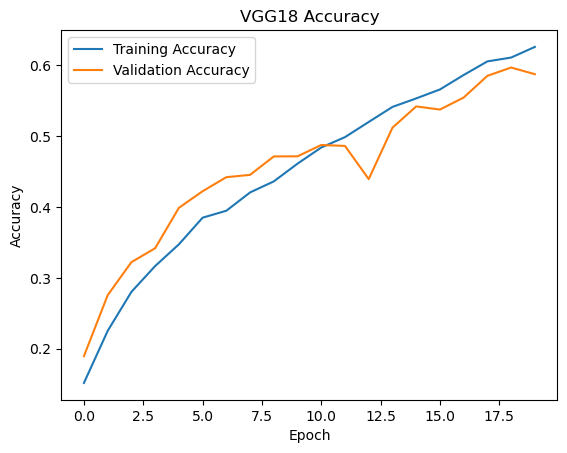

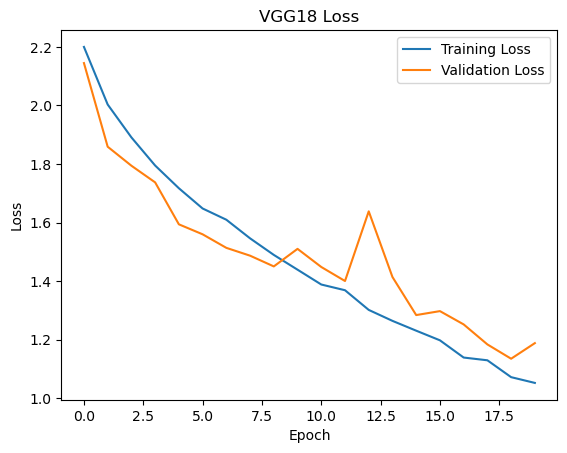

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Downsample data: use 1/10 of the training set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.1, stratify=y_train, random_state=42)

# Data preprocessing and one-hot encoding
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0
y_train, y_val, y_test = to_categorical(y_train, 10), to_categorical(y_val, 10), to_categorical(y_test, 10)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Function: Build a custom VGG18 model
def build_vgg18_model(input_shape=(32, 32, 3), num_classes=10):
    model = models.Sequential()
    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Function: Compile and train the model
def compile_and_train(model, datagen, x_train, y_train, x_val, y_val, epochs=20, batch_size=32):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs, validation_data=(x_val, y_val), 
                        callbacks=[reduce_lr, early_stopping])
    return history

# Function: Evaluate the model
def evaluate_model(model, x_test, y_test):
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    return test_loss, test_accuracy

# Train and evaluate the custom VGG18 model
print("Training VGG18...")
vgg18_model = build_vgg18_model()
history = compile_and_train(vgg18_model, datagen, x_train, y_train, x_val, y_val, epochs=20)

# Evaluate the model
test_loss, test_accuracy = evaluate_model(vgg18_model, x_test, y_test)
print(f"VGG18 - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Visualize training process
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG18 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG18 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
